Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [15]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import os

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
#pickle_file = 'notMNIST.pickle'
pickle_file = 'notMNIST_noDupNorOvlp.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (438047, 28, 28) (438047,)
Validation set (15586, 28, 28) (15586,)
Test set (13645, 28, 28) (13645,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (438047, 784) (438047, 10)
Validation set (15586, 784) (15586, 10)
Test set (13645, 784) (13645, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [9]:
num_nodes = 1024
batch_size = 512
beta = 0.01

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables Layer 1
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_nodes]))
  biases_1 = tf.Variable(tf.zeros([num_nodes]))
    
  # Variables Layer 2
  weights_2 = tf.Variable(
    tf.truncated_normal([num_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
    
  # Training computation.
  logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
  relu = tf.nn.relu(logits_1)
  logits_2 = tf.matmul(relu, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2))

  regularization = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
  loss = loss + beta * regularization
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
  # Predictions for the training
  train_prediction = tf.nn.softmax(logits_2)
    
  # Predictions for validation 
  logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
  relu_layer= tf.nn.relu(logits_1)
  logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
  valid_prediction = tf.nn.softmax(logits_2)
    
  # Predictions for test
  logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
  relu_layer= tf.nn.relu(logits_1)
  logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
  test_prediction =  tf.nn.softmax(logits_2)

In [10]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #print('Offset in iteration '+ str(step) + ' is: '+ str(offset))
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3506.561035
Minibatch accuracy: 11.5%
Validation accuracy: 33.9%
Minibatch loss at step 500: 21.353649
Minibatch accuracy: 82.6%
Validation accuracy: 83.2%
Minibatch loss at step 1000: 0.915069
Minibatch accuracy: 83.4%
Validation accuracy: 82.6%
Minibatch loss at step 1500: 0.679255
Minibatch accuracy: 84.2%
Validation accuracy: 82.3%
Minibatch loss at step 2000: 0.781053
Minibatch accuracy: 82.8%
Validation accuracy: 82.3%
Minibatch loss at step 2500: 0.683491
Minibatch accuracy: 85.4%
Validation accuracy: 82.5%
Minibatch loss at step 3000: 0.830468
Minibatch accuracy: 83.0%
Validation accuracy: 82.5%
Minibatch loss at step 3500: 0.833612
Minibatch accuracy: 80.3%
Validation accuracy: 82.7%
Minibatch loss at step 4000: 0.719391
Minibatch accuracy: 84.4%
Validation accuracy: 82.7%
Minibatch loss at step 4500: 0.794935
Minibatch accuracy: 81.4%
Validation accuracy: 82.6%
Minibatch loss at step 5000: 0.641867
Minibatch accuracy: 86.5%
Validation acc

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [11]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = batch_size * (step % 3)
    #print('Offset in iteration '+ str(step) + ' is: '+ str(offset))
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3448.093750
Minibatch accuracy: 15.6%
Validation accuracy: 37.5%
Minibatch loss at step 500: 21.140400
Minibatch accuracy: 100.0%
Validation accuracy: 78.5%
Minibatch loss at step 1000: 0.656202
Minibatch accuracy: 99.8%
Validation accuracy: 79.9%
Minibatch loss at step 1500: 0.479717
Minibatch accuracy: 99.4%
Validation accuracy: 79.6%
Minibatch loss at step 2000: 0.461609
Minibatch accuracy: 100.0%
Validation accuracy: 79.6%
Minibatch loss at step 2500: 0.462079
Minibatch accuracy: 99.8%
Validation accuracy: 79.7%
Minibatch loss at step 3000: 0.454983
Minibatch accuracy: 99.4%
Validation accuracy: 79.7%
Minibatch loss at step 3500: 0.447627
Minibatch accuracy: 100.0%
Validation accuracy: 79.6%
Minibatch loss at step 4000: 0.452734
Minibatch accuracy: 99.8%
Validation accuracy: 79.6%
Minibatch loss at step 4500: 0.447139
Minibatch accuracy: 99.2%
Validation accuracy: 79.6%
Minibatch loss at step 5000: 0.442182
Minibatch accuracy: 100.0%
Validation

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [10]:
num_nodes = 1024
batch_size = 128
beta = 0.01

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables Layer 1
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_nodes]))
  biases_1 = tf.Variable(tf.zeros([num_nodes]))
    
  # Variables Layer 2
  weights_2 = tf.Variable(
    tf.truncated_normal([num_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
    
  # Training computation.
  logits_1 = tf.add(tf.matmul(tf_train_dataset, weights_1), biases_1)
  relu = tf.nn.relu(logits_1)
  relu_drop = tf.nn.dropout(relu, 0.5)
  logits_2 = tf.add(tf.matmul(relu_drop, weights_2), biases_2)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2))

  regularization = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
  loss = loss + beta * regularization
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
  # Predictions for the training
  train_prediction = tf.nn.softmax(logits_2)
    
  # Predictions for validation 
  logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
  relu_layer= tf.nn.relu(logits_1)
  logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
  valid_prediction = tf.nn.softmax(logits_2)
    
  # Predictions for test
  logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
  relu_layer= tf.nn.relu(logits_1)
  logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
  test_prediction =  tf.nn.softmax(logits_2)

In [11]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #print('Offset in iteration '+ str(step) + ' is: '+ str(offset))
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3580.060059
Minibatch accuracy: 11.7%
Validation accuracy: 27.7%
Minibatch loss at step 500: 21.464748
Minibatch accuracy: 82.8%
Validation accuracy: 82.1%
Minibatch loss at step 1000: 0.875292
Minibatch accuracy: 85.9%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 0.998776
Minibatch accuracy: 74.2%
Validation accuracy: 81.2%
Minibatch loss at step 2000: 0.893566
Minibatch accuracy: 78.1%
Validation accuracy: 80.4%
Minibatch loss at step 2500: 0.771773
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.658304
Minibatch accuracy: 89.1%
Validation accuracy: 80.6%
Minibatch loss at step 3500: 0.814337
Minibatch accuracy: 81.2%
Validation accuracy: 81.1%
Minibatch loss at step 4000: 0.898360
Minibatch accuracy: 79.7%
Validation accuracy: 81.2%
Minibatch loss at step 4500: 0.866189
Minibatch accuracy: 79.7%
Validation accuracy: 80.7%
Minibatch loss at step 5000: 0.916550
Minibatch accuracy: 81.2%
Validation acc

In [9]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = batch_size * (step % 3)
    #print('Offset in iteration '+ str(step) + ' is: '+ str(offset))
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3404.252686
Minibatch accuracy: 10.9%
Validation accuracy: 29.8%
Minibatch loss at step 500: 21.097956
Minibatch accuracy: 100.0%
Validation accuracy: 74.4%
Minibatch loss at step 1000: 0.453407
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Minibatch loss at step 1500: 0.289589
Minibatch accuracy: 100.0%
Validation accuracy: 76.1%
Minibatch loss at step 2000: 0.283881
Minibatch accuracy: 100.0%
Validation accuracy: 76.2%
Minibatch loss at step 2500: 0.273648
Minibatch accuracy: 100.0%
Validation accuracy: 76.1%
Minibatch loss at step 3000: 0.270465
Minibatch accuracy: 100.0%
Validation accuracy: 76.1%
Minibatch loss at step 3500: 0.273427
Minibatch accuracy: 100.0%
Validation accuracy: 76.2%
Minibatch loss at step 4000: 0.267368
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Minibatch loss at step 4500: 0.265939
Minibatch accuracy: 100.0%
Validation accuracy: 76.1%
Minibatch loss at step 5000: 0.270107
Minibatch accuracy: 100.0%
Vali

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
The proposed NN design will be:
Layer1: 1024 nodes
Layer2: 512 nodes
Layer3: 256 nodes
Layer4: 128 nodes

In [28]:
import math as m

# NN architecture
num_nodes_1 = 2400
num_nodes_2 = 1200
num_nodes_3 = 600
num_nodes_4 = 300

batch_size = 1000
beta = 0.0005

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables Layer 1
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_nodes_1], stddev=m.sqrt(2.0/(image_size*image_size))))
  biases_1 = tf.Variable(tf.zeros([num_nodes_1]))
    
  # Variables Layer 2
  weights_2 = tf.Variable(
    tf.truncated_normal([num_nodes_1, num_nodes_2],stddev=m.sqrt(2.0/num_nodes_1)))
  biases_2 = tf.Variable(tf.zeros([num_nodes_2]))

  # Variables Layer 3
  weights_3 = tf.Variable(
    tf.truncated_normal([num_nodes_2, num_nodes_3],stddev=m.sqrt(2.0/num_nodes_2)))
  biases_3 = tf.Variable(tf.zeros([num_nodes_3]))

  # Variables Layer 4
  weights_4 = tf.Variable(
    tf.truncated_normal([num_nodes_3, num_nodes_4],stddev=m.sqrt(2.0/num_nodes_3)))
  biases_4 = tf.Variable(tf.zeros([num_nodes_4]))
    
  # Variables Layer 5
  weights_5 = tf.Variable(
    tf.truncated_normal([num_nodes_4, num_labels],stddev=m.sqrt(2.0/num_nodes_4)))
  biases_5 = tf.Variable(tf.zeros([num_labels]))
    
  # Training computation.
  logits_1 = tf.add(tf.matmul(tf_train_dataset, weights_1), biases_1)
  relu_2 = tf.nn.dropout(tf.nn.relu(logits_1), 0.5)
  logits_2 = tf.add(tf.matmul(relu_2, weights_2), biases_2)
  relu_3 = tf.nn.dropout(tf.nn.relu(logits_2), 0.5)
  logits_3 = tf.add(tf.matmul(relu_3, weights_3), biases_3)
  relu_4 = tf.nn.dropout(tf.nn.relu(logits_3), 0.5)
  logits_4 = tf.add(tf.matmul(relu_4, weights_4), biases_4)
  relu_5 = tf.nn.dropout(tf.nn.relu(logits_4), 0.5)
  logits_5 = tf.add(tf.matmul(relu_5, weights_5), biases_5)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_5))

  regularization = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) \
    + tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4) + tf.nn.l2_loss(weights_5)
  loss = tf.reduce_mean(loss + beta * regularization)
  
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 24000, 0.99)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
  # Predictions for the training
  train_prediction = tf.nn.softmax(logits_5)
    
  # Predictions for validation 
  logits_1 = tf.add(tf.matmul(tf_valid_dataset, weights_1), biases_1)
  relu_2 = tf.nn.relu(logits_1)
  logits_2 = tf.matmul(relu_2, weights_2) + biases_2
  relu_3 = tf.nn.relu(logits_2)
  logits_3 = tf.matmul(relu_3, weights_3) + biases_3
  relu_4 = tf.nn.relu(logits_3)
  logits_4 = tf.matmul(relu_4, weights_4) + biases_4
  relu_5 = tf.nn.relu(logits_4)
  logits_5 = tf.matmul(relu_5, weights_5) + biases_5
    
  valid_prediction = tf.nn.softmax(logits_5)
    
  # Predictions for test
  logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
  relu_2 = tf.nn.relu(logits_1)
  logits_2 = tf.matmul(relu_2, weights_2) + biases_2
  relu_3 = tf.nn.relu(logits_2)
  logits_3 = tf.matmul(relu_3, weights_3) + biases_3
  relu_4 = tf.nn.relu(logits_3)
  logits_4 = tf.matmul(relu_4, weights_4) + biases_4
  relu_5 = tf.nn.relu(logits_4)
  logits_5 = tf.matmul(relu_5, weights_5) + biases_5
    
  test_prediction =  tf.nn.softmax(logits_5)

  # Add ops to save and restore all the variables.
  saver = tf.train.Saver()

Initialized
Minibatch loss at step 0: 4.465448
Minibatch accuracy: 12.0%
Validation accuracy: 12.7%
Minibatch loss at step 500: 2.105588
Minibatch accuracy: 82.0%
Validation accuracy: 81.5%
Test accuracy: 88.3%


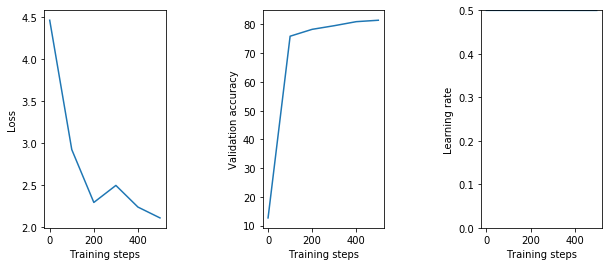

In [29]:
num_steps = 25001

#Plots
p_freq = 100
losses = []
accuracies = []
rates = []


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #print('Offset in iteration '+ str(step) + ' is: '+ str(offset))
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    opt, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    #Plot variables
    if (step % p_freq == 0):
       losses.append(l)
       accuracies.append(accuracy(valid_prediction.eval(), valid_labels))
       rates.append(learning_rate.eval())
    
    
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  save_path = saver.save(session, "/notebooks/weights/model.ckpt")
  print("Model saved in path: %s" % save_path)

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, num_steps, p_freq), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, num_steps, p_freq), accuracies)
ax2.set_ylabel("Validation accuracy")
ax2.set_xlabel("Training steps")
ax3.plot(range(0, num_steps, p_freq), rates)
ax3.set_ylabel("Learning rate")
ax3.set_xlabel("Training steps")
ax3.set_ylim([0, 1])
plt.show()

In [18]:
with tf.Session(graph=graph) as session:
  saver.restore(session, "/notebooks/weights/model.ckpt")
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

INFO:tensorflow:Restoring parameters from /notebooks/weights/model.ckpt
Test accuracy: 96.0%
